In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.feature import OneHotEncoderEstimator, Binarizer, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.sql.functions import * 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN,  SMOTETomek
from pyspark.ml.linalg import Vectors
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule
from pyspark.mllib.tree import GradientBoostedTrees
import warnings
warnings.filterwarnings('ignore')

In [2]:
#set up plot size
%matplotlib inline
rcParams['figure.figsize'] = 12, 8

In [3]:
spark = SparkSession.builder.appName('strroke').getOrCreate()

In [4]:
#read data from google bucket
input_dir = 'gs://data-stroke/'
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferSchema='true').load(input_dir+'stroke_data.csv')

#convert to panda dataframe for later use
df_pd = df.toPandas()

#show the data
df.show(3)


+------+----+--------+------------+------+-------------+---------------+-----+
|gender| age|diabetes|hypertension|stroke|heart disease|smoking history|  BMI|
+------+----+--------+------------+------+-------------+---------------+-----+
|Female|80.0|       0|           0|     0|            1|          never|25.19|
|Female|54.0|       0|           0|     0|            0|           null| null|
|  Male|28.0|       0|           0|     0|            0|          never| null|
+------+----+--------+------------+------+-------------+---------------+-----+
only showing top 3 rows



In [5]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- heart disease: integer (nullable = true)
 |-- smoking history: string (nullable = true)
 |-- BMI: double (nullable = true)



In [6]:
#EDA
df.groupBy(df['stroke']).count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1| 1426|
|     0|98574|
+------+-----+



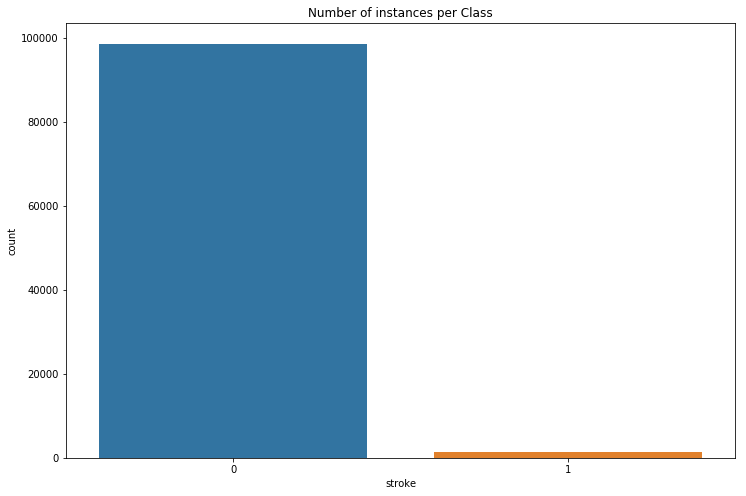

In [7]:
#plot class distribution
plt.title("Number of instances per Class")
sns.countplot(df_pd.stroke);
plt.show()

In [8]:
# impute BMI null records using BMI Distribution by Age Calculator for the United States
#reference: https://dqydj.com/bmi-distribution-by-age-calculator-for-the-united-states/


df_2 = df_pd[(df_pd['age']>=2) & (df_pd['age']<=3)]
value = {'BMI': 16.5}
df_2 = df_2.fillna(value = value)

df_4 = df_pd[(df_pd['age']>=4) & (df_pd['age']<=5)]
value = {'BMI': 16.5}
df_4 = df_4.fillna(value = value)

df_6 = df_pd[(df_pd['age']>=6) & (df_pd['age']<=7)]
value = {'BMI': 17.2}
df_6 = df_6.fillna(value = value)

df_8 = df_pd[(df_pd['age']>=8) & (df_pd['age']<=9)]
value = {'BMI': 18.3}
df_8 = df_8.fillna(value = value)

df_10 = df_pd[(df_pd['age']>=10) & (df_pd['age']<=11)]
value = {'BMI': 20.2}
df_10 = df_10.fillna(value = value)

df_12 = df_pd[(df_pd['age']>=12) & (df_pd['age']<=13)]
value = {'BMI': 22.0}
df_12 = df_12.fillna(value = value)

df_14 = df_pd[(df_pd['age']>=14) & (df_pd['age']<=15)]
value = {'BMI': 23.4}
df_14 = df_14.fillna(value = value)

df_16 = df_pd[(df_pd['age']>=16) & (df_pd['age']<=17)]
value = {'BMI': 25.3}
df_16 = df_16.fillna(value = value)

df_18 = df_pd[(df_pd['age']>=18) & (df_pd['age']<=24)]
value = {'BMI': 27.1}
df_18 = df_18.fillna(value = value)

df_25 = df_pd[(df_pd['age']>=25) & (df_pd['age']<=29)]
value = {'BMI': 27.9}
df_25 = df_25.fillna(value = value)

df_30 = df_pd[(df_pd['age']>=30) & (df_pd['age']<=34)]
value = {'BMI': 29.6}
df_30 = df_30.fillna(value = value)

df_35 = df_pd[(df_pd['age']>=35) & (df_pd['age']<=39)]
value = {'BMI': 30.2}
df_35 = df_35.fillna(value = value)

df_40 = df_pd[(df_pd['age']>=40) & (df_pd['age']<=44)]
value = {'BMI': 30.1}
df_40 = df_40.fillna(value = value)

df_45 = df_pd[(df_pd['age']>=45) & (df_pd['age']<=49)]
value = {'BMI': 29.7}
df_45 = df_45.fillna(value = value)

df_50 = df_pd[(df_pd['age']>=50) & (df_pd['age']<=54)]
value = {'BMI': 30.1}
df_50 = df_50.fillna(value = value)

df_55 = df_pd[(df_pd['age']>=55) & (df_pd['age']<=59)]
value = {'BMI': 29.8}
df_55 = df_55.fillna(value = value)

df_60 = df_pd[(df_pd['age']>=60) & (df_pd['age']<=64)]
value = {'BMI': 30.5}
df_60 = df_60.fillna(value = value)

df_65 = df_pd[(df_pd['age']>=65) & (df_pd['age']<=69)]
value = {'BMI': 30.0}
df_65 = df_65.fillna(value = value)

df_70 = df_pd[(df_pd['age']>=70) & (df_pd['age']<=74)]
value = {'BMI': 29.8}
df_70 = df_70.fillna(value = value)

df_75 = df_pd[(df_pd['age']>=75)]
value = {'BMI': 28.1}
df_75 = df_75.fillna(value = value)


all_frames = [df_2, df_4, df_6, df_8, df_10, df_12, df_14, df_16, df_18, df_25, df_30, df_35, df_40, df_45, df_50, df_55, df_60, df_65, df_70, df_75]

df_combined = pd.concat(all_frames)



In [9]:
df_combined["smoking history"].value_counts()
df_combined['stroke'].value_counts()

0    96474
1     1425
Name: stroke, dtype: int64

In [10]:
df_combined = df_combined.dropna()

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64024 entries, 347 to 99982
Data columns (total 8 columns):
gender             64024 non-null object
age                64024 non-null float64
diabetes           64024 non-null int32
hypertension       64024 non-null int32
stroke             64024 non-null int32
heart disease      64024 non-null int32
smoking history    64024 non-null object
BMI                64024 non-null float64
dtypes: float64(2), int32(4), object(2)
memory usage: 3.4+ MB


In [11]:
categorical_cols = ['gender', 'smoking history']
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df_combined[categorical_cols] = df_combined[categorical_cols].apply(lambda col: le.fit_transform(col))
df_combined[categorical_cols].head(10)

#casting age to int
df_combined['age'] = df_combined['age'].astype('int32') 

In [118]:
# split into train-test and apply sampling on train data
X = df_combined.filter(items=['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI'])
Y = df_combined.filter(items=['stroke'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

#undersampling
sm = EditedNearestNeighbours(n_neighbors=3)
X_train_sam, Y_train_sam = sm.fit_sample(X_train, Y_train)

#oversampling
sm = SMOTE()
X_train_sam, Y_train_sam = sm.fit_sample(X_train_sam, Y_train_sam)



df_X_train_sam = pd.DataFrame(X_train_sam,columns=['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI'])
df_Y_train_sam = pd.DataFrame(Y_train_sam, columns = ['stroke'])

# X_train_sam
#combine processed sample 
df_combine_sam = df_X_train_sam.combine_first(df_Y_train_sam)
df_combine_test = X_test.combine_first(Y_test)

df_combine_sam['stroke'].value_counts()

1.0    48285
0.0    48285
Name: stroke, dtype: int64

In [13]:
df_combine_sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96570 entries, 0 to 96569
Data columns (total 8 columns):
BMI                96570 non-null float64
age                96570 non-null float64
diabetes           96570 non-null float64
gender             96570 non-null float64
heart disease      96570 non-null float64
hypertension       96570 non-null float64
smoking history    96570 non-null float64
stroke             96570 non-null float64
dtypes: float64(8)
memory usage: 5.9 MB


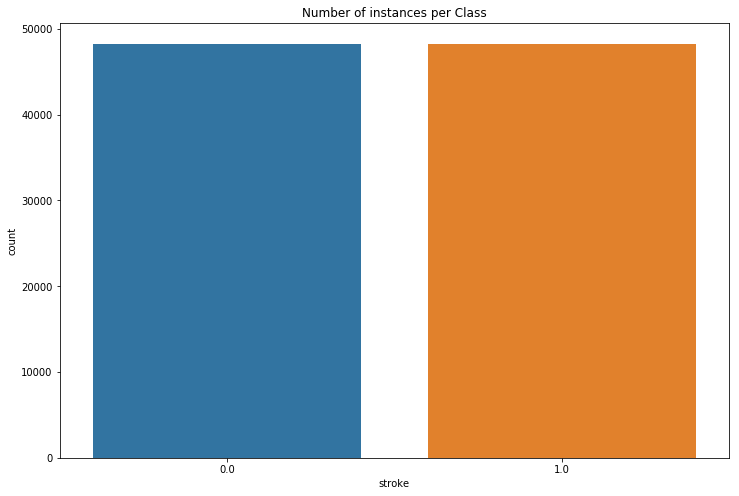

In [14]:
#plot class distribution after processing
plt.title("Number of instances per Class")
sns.countplot(df_combine_sam.stroke);
plt.show()

In [15]:
#convert to spark dataframe
df_combined_converted = spark.createDataFrame(df_combine_sam)
df_combined_converted_test = spark.createDataFrame(df_combine_test)

In [16]:
df_combined_converted.printSchema()

root
 |-- BMI: double (nullable = true)
 |-- age: double (nullable = true)
 |-- diabetes: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- heart disease: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- smoking history: double (nullable = true)
 |-- stroke: double (nullable = true)



In [17]:
#vector assempler - to vectorize features
featureColumns = ['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI']
assembler = VectorAssembler(inputCols = featureColumns, outputCol = 'features')
df_assembled = assembler.transform(df_combined_converted)
df_assembled_test = assembler.transform(df_combined_converted_test)

In [18]:
#train-test data
(trainingData, testData) = (df_assembled, df_assembled_test)
print("Distribution of Ones and Zeros in trainingData is: ", trainingData.groupBy('stroke').count().take(3))


Distribution of Ones and Zeros in trainingData is:  [Row(stroke=0.0, count=48285), Row(stroke=1.0, count=48285)]


In [80]:
#training and evaluation
model_rf = RandomForestClassifier(labelCol="stroke", featuresCol="features", numTrees=30,maxDepth=4, impurity='gini', seed=60)
pipeline = Pipeline(stages=[model_rf])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

In [81]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='stroke')
print('Random Forest Test Area Under ROC', evaluator.evaluate(predictions))

Random Forest Test Area Under ROC 0.7963780149041073


In [116]:
#training and evaluation
model_rf = GBTClassifier(labelCol="stroke", featuresCol="features", maxIter=10, subsamplingRate=0.8, maxDepth=3, lossType="logistic", stepSize=0.05,seed=60)
pipeline = Pipeline(stages=[model_rf])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

In [117]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='stroke')
print('Gradient Boosting Tree Area Under ROC', evaluator.evaluate(predictions))

Gradient Boosting Tree Area Under ROC 0.7608588532125541
